In [3]:
!pip install -qq -e git+http://github.com/tensorflow/cleverhans.git#egg=cleverhans
import sys
sys.path.append('/content/src/cleverhans')
import cleverhans

     |████████████████████████████████| 163kB 8.9MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 


In [4]:
import tensorflow as tf
from cleverhans.future.tf2.attacks import fast_gradient_method
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from wresnet import WideResidualNetwork

import gzip
import pickle
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

print("\nTensorflow Version: " + tf.__version__)


# defined utility functions
from preprocessing import preprocessing_data


Tensorflow Version: 2.4.0


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp drive/MyDrive/adversarial_examples_parseval_net/data.pz sample_data/

In [5]:
def read_data():
    with open("data.pz", 'rb') as file_:
        with gzip.GzipFile(fileobj=file_) as gzf:
            data = pickle.load(gzf, encoding='latin1', fix_imports=True)
    return data
data = read_data()

In [6]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=10,
                               width_shift_range=5./32,
                               height_shift_range=5./32,)

In [7]:
X, y = preprocessing_data(data)
X_train, X_test, Y_train, y_test = train_test_split(X, y, test_size = 0.1)
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size = 0.1)

In [8]:
EPOCHS = 50
BS = 64
init = (32, 32,1)
sgd = SGD(lr=0.1, momentum=0.9)
parameter = {'epochs': EPOCHS, 'batch_size': BS, 'optimizer': sgd}

In [9]:
wresnet_ins = WideResidualNetwork(init, 0.0001, 0.9, nb_classes=4, N=2, k=1, dropout=0.0)

In [ ]:
model = wresnet_ins.create_wide_residual_network()
model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["acc"])
model.fit(generator.flow(x_train, y_train, batch_size=BS),steps_per_epoch=len(x_train) // BS,
          validation_data=(x_val, y_val),epochs = EPOCHS,
          validation_steps=x_val.shape[0] // BS,)

In [66]:
import cv2
image = data[8] 
img= cv2.resize(image['crop'], (32, 32))

img = img.reshape(1, 32, 32, 1)

In [67]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
label_orginal = image['label']
label = y[8]

In [84]:
label_orginal

'open'

In [68]:
def adversarial(model, img, label, epsilon):
    original_image = img
    original_image = tf.convert_to_tensor(original_image.reshape((1,32,32))) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor
    original_label = label
    original_label = np.reshape(np.argmax(original_label), (1,)).astype('int64')
    adv_example_targeted_label = fast_gradient_method(model, original_image, epsilon, np.inf,y=original_label, targeted=False)
    adv_example_targeted_label = np.array(adv_example_targeted_label).reshape(32,32)
    return adv_example_targeted_label

In [85]:
img_50 = adversarial(model,img, label,epsilon=0.003)
img_50 = (img_50 - img_50.min()) * 255 / (img_50.max() - img_50.min())
label_50 = np.argmax(model.predict(img_50.reshape(1,32,32)))
img_45 = adversarial(model,img, label,epsilon=0.005)
img_45 = (img_45 - img_45.min()) * 255 / (img_45.max() - img_45.min())
label_45 = np.argmax(model.predict(img_45.reshape(1,32,32)))
img_40 = adversarial(model,img, label,epsilon=0.01)
img_40 = (img_40 - img_40.min()) * 255 / (img_40.max() - img_40.min())
label_40 = np.argmax(model.predict(img_40.reshape(1,32,32)))
img_33 = adversarial(model,img, label,epsilon=0.02)
img_33 = (img_33 - img_33.min()) * 255 / (img_33.max() - img_33.min())
label_33 = np.argmax(model.predict(img_33.reshape(1,32,32)))

In [79]:
print("img_50: {0} \n, img_45: {1}, img_40: {2}, img_33:{3}".format(label_50,label_45,label_40, label_33))

img_50: 1 
, img_45: 1, img_40: 1, img_33:1


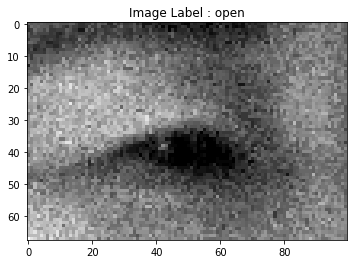

In [80]:
original_img = data[8]['crop']
label_orginal
recovered = (original_img - original_img.min()) * 255 / (original_img.max() - original_img.min())
plt.title("Image Label : {0}".format(label_orginal))
plt.imshow(recovered, cmap='gray')
plt.savefig('Original.png')

In [72]:
data[0]['label']

'open'

<Figure size 432x288 with 0 Axes>

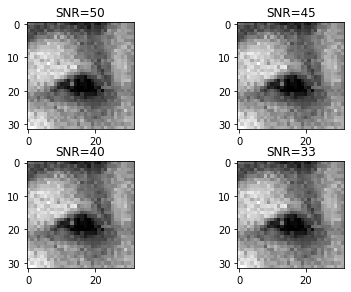

In [82]:
plt.figure(1)
fig, _ = plt.subplots(2, 2)
fig.tight_layout()

plt.subplot(221)
plt.title("SNR=50")
plt.imshow(img_50,cmap='gray' )
plt.subplot(222)
plt.title("SNR=45")
plt.imshow(img_45,cmap='gray' )
plt.subplot(223)
plt.title("SNR=40")
plt.imshow(img_40, cmap='gray')
plt.subplot(224)
plt.title("SNR=33")
plt.imshow(img_33, cmap='gray')
plt.savefig('PertubatedImagesforDifferentSNR.png')
plt.show()